Data obtained via FOIA request from the United States Small Businses Administration. 

## Import libraries

In [3]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)
data_dir = '/content/drive/MyDrive/SURI/Studies/2022_Wildfires/SBA/'

# Import needed packages
! pip install geopandas
! pip install geopy
! pip install -U plotly
! pip install us
! pip install cpi

import os
import pandas as pd
import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import geopy.distance
from shapely.geometry import Point, Polygon
import csv
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy 
from scipy import stats as sts
import plotly.express as px
from numpy.random import default_rng
from plotnine import *
from scipy.stats import expon
import cpi

import us
plt.style.use("ggplot")

Mounted at /content/drive/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 28.9 MB 1.5 MB/s 


/usr/local/lib/python3.7/dist-packages/cpi/__init__.py:46: StaleDataWarning: CPI data is out of date. To accurately inflate to today's dollars, you must run `cpi.update()`.
  warnings.warn(StaleDataWarning())


# Freedom of Information Act, collect in 2019 by Goldstein.

## Read in data

In [4]:
# Approved loans
df_approvals = pd.read_csv(data_dir + "data/sba_disaster_loan_approvals.csv.gz")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (1,2,3,7,10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
# Withdrawn loans
df_withdrawals = pd.read_csv(data_dir + "data/sba_disaster_loan_withdrawals.csv.gz")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (1,2,3,7,10,13,14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
# Declined loans
df_declines = pd.read_csv(data_dir + "data/sba_disaster_loan_declines.csv.gz")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (1,2,3,7,10,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Data cleaning

In [7]:
# Remove whitespace from decline code fields
df_declines[['DECL_CODES','DECL_CODES2','DECL_CODES3','DECL_CODES4','FEMA_DECL']] = df_declines[['DECL_CODES','DECL_CODES2','DECL_CODES3','DECL_CODES4','FEMA_DECL']].apply(lambda s: s.str.strip())

In [8]:
# Remove whitespace from ends of state codes
df_approvals[['STATE']] = df_approvals[['STATE']].apply(lambda s: s.str.strip())
df_withdrawals[['STATE']] = df_withdrawals[['STATE']].apply(lambda s: s.str.strip())
df_declines[['STATE']] = df_declines[['STATE']].apply(lambda s: s.str.strip())

In [ ]:
# Remove business loans
#df_approvals = df_approvals[df_approvals['LOAN_TYPE'] == 'H'].reset_index(drop=True)
#df_declines = df_declines[df_declines['LOAN_TYPE'] == 'H'].reset_index(drop=True)

In [9]:
# Looking only at HOME LOANS & LOANS BELOW 200K
cols = ['ORIGINAL_APPROVAL_AMOUNT']
mask = df_approvals[cols].applymap(lambda x: isinstance(x, (int, float)))
df_approvals[cols] = df_approvals[cols].where(mask)
df_approvals = df_approvals[df_approvals['ORIGINAL_APPROVAL_AMOUNT'].astype(float)<250000].reset_index(drop=True)
df_approvals['FEMA_DECL'] = pd.to_numeric(df_approvals['FEMA_DECL'].str.replace('DR',''),errors='coerce')

cols = ['TOT_ORIG_VER_LOSS']
mask = df_declines[cols].applymap(lambda x: isinstance(x, (int, float)))
df_declines[cols] = df_declines[cols].where(mask)
df_declines = df_declines[(df_declines['TOT_ORIG_VER_LOSS_RE'] > 100) & (df_declines['TOT_ORIG_VER_LOSS_RE'].astype(float)<250000)]

## Bring values to 2022 dollars

In [14]:
# Inflation rates
inflation_dict = {2001 : 1.62,
                  2002 : 1.60,
                  2003 : 1.56,
                  2004 : 1.52,
                  2005 : 1.47,
                  2006 : 1.43,
                  2007 : 1.39,
                  2008 : 1.34,
                  2009 : 1.34,
                  2010 : 1.318,
                  2011 : 1.28,
                  2012 : 1.25,
                  2013 : 1.23,
                  2014 : 1.21,
                  2015 : 1.21,
                  2016 : 1.20,
                  2017 : 1.17,
                  2018 : 1.14,
                  2019 : 1.12,
                  2020 : 1.11,
                  2021 : 1.06,
                  2022 : 1.0}

#df_approvals['InflationRates'] = df_approvals['FY'].astype(int).map(inflation_dict)
df_approvals['InflationRates'] = df_approvals['FY'].apply(lambda x: cpi.inflate(1,x,to=2021))
df_approvals['ORIGINAL_APPROVAL_AMOUNT_2022_DOLLARS'] = df_approvals['ORIGINAL_APPROVAL_AMOUNT'] #* df_approvals['InflationRates']

## All disaster in the database

In [11]:
print('The size of the dataset',len(df_approvals.index) +\
                                len(df_declines.index))

print('Approvals',len(df_approvals.index))

print('The approval rate for homeowners was', len(df_approvals.index)\
      /(len(df_approvals.index)\
      + len(df_declines.index)))

print('Median approved amount', df_approvals['ORIGINAL_APPROVAL_AMOUNT_2022_DOLLARS'].astype(int).sum()/10**9)
print('Mean approved amount', df_approvals['ORIGINAL_APPROVAL_AMOUNT_2022_DOLLARS'].astype(int).mean())

The size of the dataset 553471
Approvals 277337
The approval rate for homeowners was 0.5010867778076901
Median approved amount 14.355418306
Mean approved amount 51761.64127397354


/usr/local/lib/python3.7/dist-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/usr/local/lib/python3.7/dist-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /content/drive/MyDrive/SURI/Studies/2022_Wildfires/Figures/Fig_SBAFOIA_ApprovedAmountHistogram.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)


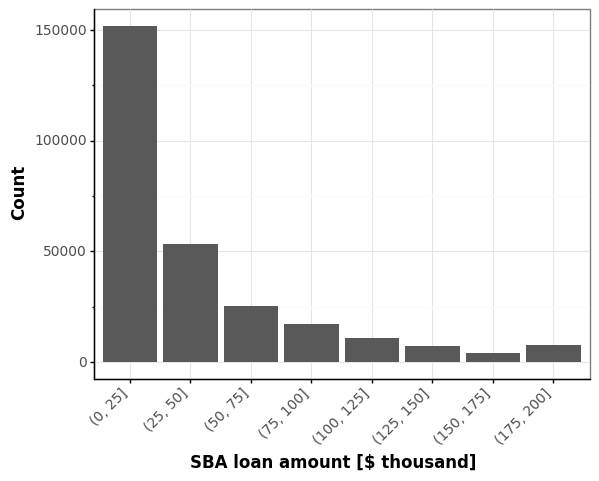

<ggplot: (8765806325581)>

In [20]:
df_Plot = df_approvals.copy()
df_Plot['ORIGINAL_APPROVAL_AMOUNT_2022_DOLLARS'] = df_Plot['ORIGINAL_APPROVAL_AMOUNT_2022_DOLLARS'].apply(lambda x: 200000 if x > 200000 else x)
df_Plot['ORIGINAL_APPROVAL_AMOUNT_2022_DOLLARS'] = df_Plot['ORIGINAL_APPROVAL_AMOUNT_2022_DOLLARS'].div(1000)
df_Plot['PlotValues'] = pd.cut(df_Plot['ORIGINAL_APPROVAL_AMOUNT_2022_DOLLARS'],bins=list(range(0,350,25)))


plot_base = ggplot(df_Plot,aes(x='PlotValues')) + geom_bar()

plot_clean = plot_base + theme_bw()
plot_clean = plot_clean + theme(
    axis_line=element_line(size=1),
    axis_text=element_text(size=10),
    axis_title=element_text(size=12,face="bold"),
    axis_text_x = element_text(angle = 45, hjust=1)
) +\
scale_x_discrete(name = 'SBA loan amount [$ thousand]') +\
scale_y_continuous(name = 'Count')#, limits=[0,np.NaN])


ggsave(plot_clean, filename = 'Fig_SBAFOIA_ApprovedAmountHistogram.pdf', path = '/content/drive/MyDrive/SURI/Studies/2022_Wildfires/Figures/')
plot_clean

## All disasters in CA

In [ ]:
df_approvals_CA = df_approvals[df_approvals['STATE']=='CA'].copy()
df_declines_CA = df_declines[df_declines['STATE']=='CA'].copy()

print('The size of the dataset',len(df_approvals_CA.index) +\
                                len(df_declines_CA.index))

print('Approvals',len(df_approvals_CA.index))

print('The approval rate for homeowners was', len(df_approvals_CA.index)\
      /(len(df_approvals_CA.index)\
      + len(df_declines_CA.index)))

print('Median approved amount', df_approvals_CA['ORIGINAL_APPROVAL_AMOUNT_2022_DOLLARS'].astype(int).sum()/10**9)
print('Mean approved amount', df_approvals_CA['ORIGINAL_APPROVAL_AMOUNT_2022_DOLLARS'].astype(int).mean())

The size of the dataset 7738
Approvals 4086
The approval rate for homeowners was 0.528043422072887
Median approved amount 0.26324876
Mean approved amount 64427.00930004895


## 2017 Fires (FEMA 4344 & 4353)

In [ ]:
# Gather data for the 2017 CA Wildfires
# Note: one cannot filter based on FEMA Declaration codes because most have 'NaN'
# Assumption: all 2018 applications are associated with disasters 4344 and 4353
df_Approvals_2017Wildfires = df_approvals_CA[df_approvals_CA['FY'] >= 2017].copy()
df_Declines_2017Wildfires = df_declines_CA[df_declines_CA['FY'] >= 2017].copy()

print('The size of the dataset',len(df_Approvals_2017Wildfires.index) +\
                                len(df_Declines_2017Wildfires.index))

print('Approvals',len(df_Approvals_2017Wildfires.index))

print('The approval rate for homeowners was', len(df_Approvals_2017Wildfires.index)\
      /(len(df_Approvals_2017Wildfires.index)\
      + len(df_Declines_2017Wildfires.index)))

print('Median approved amount', df_Approvals_2017Wildfires['ORIGINAL_APPROVAL_AMOUNT_2022_DOLLARS'].astype(int).sum()/10**9)
print('Mean approved amount', df_Approvals_2017Wildfires['ORIGINAL_APPROVAL_AMOUNT_2022_DOLLARS'].astype(int).mean())

The size of the dataset 966
Approvals 693
The approval rate for homeowners was 0.717391304347826
Median approved amount 0.066808846
Mean approved amount 96405.26118326119


#### Associate entries with a FEMA Disaster Declaration

In [ ]:
# Get only the entries with an associated valid FEMA declaration number
df_approvals['FEMA_DECL'] = df_approvals['FEMA_DECL'].fillna(0)
df_approvals['FEMA Disaster Number'] = df_approvals['FEMA_DECL'].astype(int).reset_index(drop=True)

df_FEMA_Declarations = pd.read_csv('/content/drive/MyDrive/SURI/Studies/2022_Wildfires/' + "DisasterDeclarationsSummaries.csv")
df_FEMA_Declarations = df_FEMA_Declarations[df_FEMA_Declarations['fyDeclared']>2000]
df_FEMA_Declarations = df_FEMA_Declarations[df_FEMA_Declarations['declarationType'] == 'DR']

codes = df_FEMA_Declarations['disasterNumber']
years = df_FEMA_Declarations['fyDeclared']
FEMADeclaration_dict = dict(zip(codes, years))

hazard = df_FEMA_Declarations['incidentType']
FEMADeclarationHazard_dict = dict(zip(codes, hazard))

# Disaster year
df_approvals['Year'] = df_approvals['FEMA Disaster Number'].map(FEMADeclaration_dict)
df_approvals = df_approvals[df_approvals['Year'].isna() == False].reset_index(drop=True)

# Disaster hazard
df_approvals['Hazard'] = df_approvals['FEMA Disaster Number'].map(FEMADeclarationHazard_dict)
df_approvals['Hazard'] = df_approvals['Hazard'].replace(np.nan,'Unknown')

# Inflation rate since year
df_approvals['InflationRate'] = df_approvals['Year'].map(inflation_dict)

## Check data variability per state

/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:360: PlotnineWarning: stat_boxplot : Removed 2868 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
/usr/local/lib/python3.7/dist-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(data['x']):


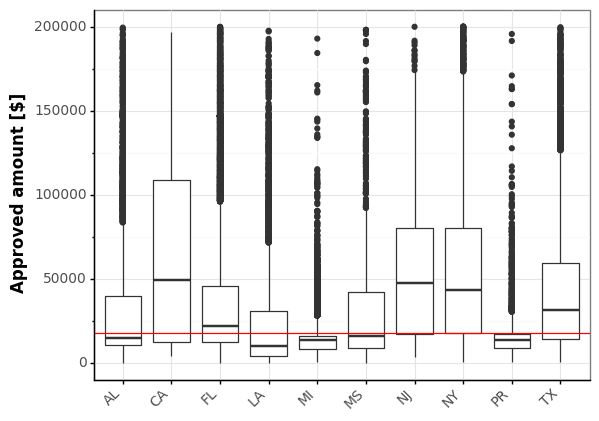

<ggplot: (8744536068033)>

In [ ]:
# Create a box plot graph
df_Box = df_approvals.copy()
df_Box['ORIGINAL_APPROVAL_AMOUNT_2022_DOLLARS'] = df_Box['ORIGINAL_APPROVAL_AMOUNT_2022_DOLLARS'].astype('float')
median_all = df_Box['ORIGINAL_APPROVAL_AMOUNT_2022_DOLLARS'].median()

# Take only the states with the most data
df_Box = df_Box[df_Box['STATE'].isin(['FL','LA','TX','PR','NY','MS','MI','NJ','AL','CA'])]
plot_base = ggplot(df_Box) + geom_boxplot(aes(x='STATE', y='ORIGINAL_APPROVAL_AMOUNT_2022_DOLLARS')) + geom_hline(aes(yintercept=median_all),color='red')

plot_clean = plot_base + theme_bw()
plot_clean = plot_clean + theme(
    axis_line=element_line(size=1),
    axis_text=element_text(size=10),
    axis_title=element_text(size=12,face="bold"),
    axis_text_x = element_text(angle = 45, hjust=1)
) +\
scale_x_discrete(name = '') +\
scale_y_continuous(name = 'Approved amount [$]',limits=[0,200000])
plot_clean

In [ ]:
def getApprovalAmount(df_sba,state,hazard):

    df = df_sba.copy()

    # filter by state
    if state in df['STATE'].unique():
        df = df[df['STATE'] == state]

    else:
        return 0,0,0,0

    # filter by hazard
    if hazard in df['Hazard'].unique():
        df = df[df['Hazard'] == hazard]

    else:
        return 0,0,0,0

    #if len(df.index) < 100:
    #   print('Warning: small dataset!',state,hazard,len(df.index))


    # approval rate
    return len(df.index),df['ORIGINAL_APPROVAL_AMOUNT_2022_DOLLARS'].mean(),df['ORIGINAL_APPROVAL_AMOUNT_2022_DOLLARS'].quantile(0.9),df['ORIGINAL_APPROVAL_AMOUNT_2022_DOLLARS'].quantile(0.1)

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 26 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:452: PlotnineWarning: geom_linerange : Removed 27 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


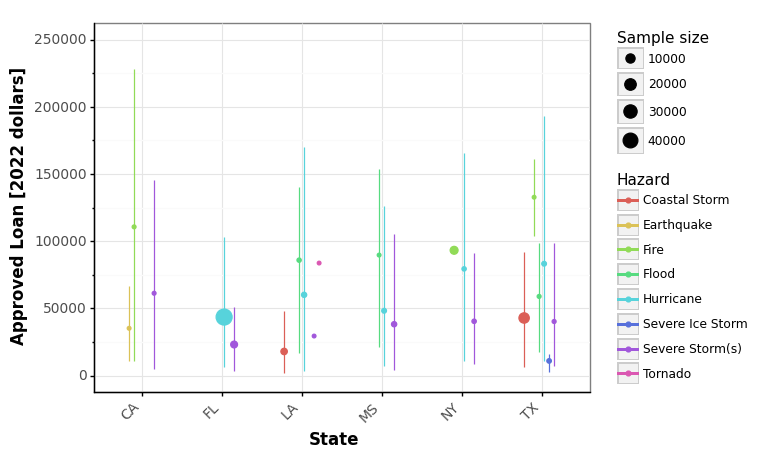

<ggplot: (8744542591665)>

In [ ]:
df_ApprovalRates = pd.DataFrame()

state = []
hazard = []
ss = []
values = []
values_max = []
values_min = []

df_approvals_selected = df_approvals[df_approvals['STATE'].isin(['CA','FL','NY','TX','LA','MS'])].reset_index(drop=True)

for i in df_approvals_selected['STATE'].unique():
  for j in df_approvals_selected['Hazard'].unique():
        state.append(i)
        hazard.append(j)
        sample_size,ratio_m,v_max,v_min = getApprovalAmount(df_approvals_selected,i,j)
        ss.append(sample_size + 0.01)
        values.append(ratio_m)
        values_max.append(v_max)
        values_min.append(v_min)

df_ApprovalRates['State'] = state
df_ApprovalRates['Hazard'] = hazard
df_ApprovalRates['Sample size'] = ss
#df_ApprovalRates['Sample size'] = pd.cut(df_ApprovalRates['SampleSize_number'],bins=list(range(0,50001,10000)))
df_ApprovalRates['Ratio'] = values
df_ApprovalRates['Ratio_ymin'] = values_min
df_ApprovalRates['Ratio_ymax'] = values_max
#df_ApprovalRates.to_csv(data_dir+'df_ApprovalRates.txt')

df_ApprovalRates.sort_values('Ratio')
plot_base = ggplot(df_ApprovalRates,aes(x='State',y='Ratio', color='Hazard'))\
            + geom_point(aes(size='Sample size'),position=position_dodge(0.5))\
            + geom_linerange(aes(ymin='Ratio_ymin', ymax ='Ratio_ymax'),position=position_dodge(0.5))

plot_clean = plot_base + theme_bw()
plot_clean = plot_clean + theme(
    axis_line=element_line(size=1),
    axis_text=element_text(size=10),
    axis_title=element_text(size=12,face="bold"),
    axis_text_x = element_text(angle = 45, hjust=1)
) +\
scale_y_continuous(name = 'Approved Loan [2022 dollars]', limits=[1,250000])


#ggsave(plot_clean, filename = 'Fig_SBA_ApprovedRatio_byState.pdf', path = '/content/drive/MyDrive/SURI/Studies/2022_Wildfires/Figures/')
plot_clean

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/usr/local/lib/python3.7/dist-packages/plotnine/scales/scale_size.py:50: PlotnineWarning: Using alpha for a discrete variable is not advised.
  PlotnineWarning


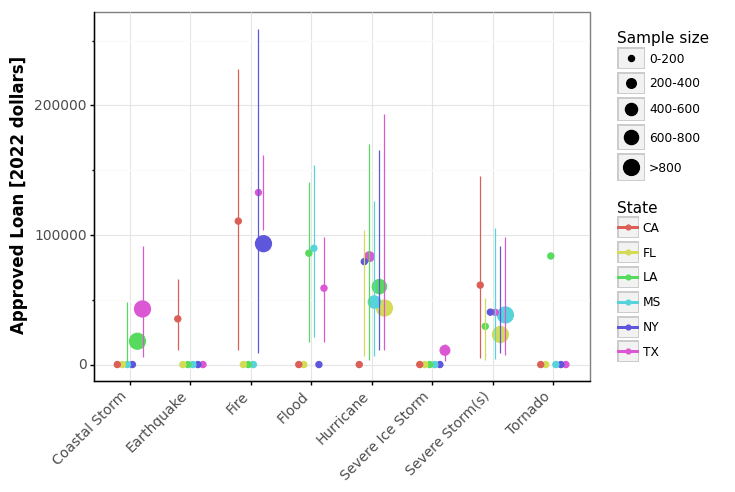

<ggplot: (8744537180765)>

In [ ]:
df_ApprovalRates = pd.DataFrame()

state = []
hazard = []
ss = []
values = []
values_max = []
values_min = []

df_approvals_selected = df_approvals[df_approvals['STATE'].isin(['CA','FL','NY','TX','LA','MS'])]

for i in df_approvals_selected['STATE'].unique():
  for j in df_approvals_selected['Hazard'].unique():
        state.append(i)
        hazard.append(j)
        sample_size,ratio_m,v_max,v_min = getApprovalAmount(df_approvals_selected,i,j)
        ss.append(sample_size)
        values.append(ratio_m)
        values_max.append(v_max)
        values_min.append(v_min)

df_ApprovalRates['State'] = state
df_ApprovalRates['Hazard'] = hazard
df_ApprovalRates['SampleSize_number'] = ss
df_ApprovalRates['Sample size'] = df_ApprovalRates['SampleSize_number'].apply(lambda x: '0-200' if x < 200 else\
                                                                              ('200-400' if x < 400 else\
                                                                              ('400-600' if x < 600 else\
                                                                              ('600-800' if x < 800 else '>800'
                                                                              ))))
df_ApprovalRates['Ratio'] = values
df_ApprovalRates['Ratio_ymin'] = values_min
df_ApprovalRates['Ratio_ymax'] = values_max

df_ApprovalRates.sort_values('Ratio')
plot_base = ggplot(df_ApprovalRates,aes(x='Hazard',y='Ratio', color='State'))\
            + geom_point(aes(size='Sample size'),position=position_dodge(0.5))\
            + geom_linerange(aes(ymin='Ratio_ymin', ymax ='Ratio_ymax'),position=position_dodge(0.5))

plot_clean = plot_base + theme_bw()
plot_clean = plot_clean + theme(
    axis_line=element_line(size=1),
    axis_text=element_text(size=10),
    axis_title=element_text(size=12,face="bold"),
    axis_text_x = element_text(angle = 45, hjust=1)
) +\
scale_x_discrete(name = '') +\
scale_y_continuous(name = 'Approved Loan [2022 dollars]')


#ggsave(plot_clean, filename = 'Fig_SBA_ApprovedRatio_byState.pdf', path = '/content/drive/MyDrive/SURI/Studies/2022_Wildfires/Figures/')
plot_clean

# Data from https://data.sba.gov/dataset/disaster-loan-data

In [ ]:
# Import needed packages
! pip install geopandas
! pip install geopy
! pip install -U plotly

import pandas as pd
import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import geopy.distance
from shapely.geometry import Point, Polygon
import csv
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy 
from scipy import stats as sts
import plotly.express as px
from numpy.random import default_rng
from plotnine import *

rng = default_rng(13)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#### Read data files

In [ ]:
df_SBA_2008 = pd.read_csv(data_dir + "SBA_FY08.txt")
df_SBA_2009 = pd.read_csv(data_dir + "SBA_FY09.txt")
df_SBA_2010 = pd.read_csv(data_dir + "SBA_FY10.txt")
df_SBA_2011 = pd.read_csv(data_dir + "SBA_FY11.txt")
df_SBA_2012 = pd.read_csv(data_dir + "SBA_FY12.txt")
df_SBA_2013 = pd.read_csv(data_dir + "SBA_FY13.txt")
df_SBA_2014 = pd.read_csv(data_dir + "SBA_FY14.txt")
df_SBA_2015 = pd.read_csv(data_dir + "SBA_FY15.txt")
df_SBA_2016 = pd.read_csv(data_dir + "SBA_FY16.txt")
df_SBA_2017 = pd.read_csv(data_dir + "SBA_FY17.txt")
df_SBA_2018 = pd.read_csv(data_dir + "SBA_FY18.txt")
df_SBA_2019 = pd.read_csv(data_dir + "SBA_FY19.txt")

df_SBA_All = pd.DataFrame()
df_SBA_All = df_SBA_All.append(df_SBA_2008[['FEMA Disaster Number','Damaged Property State Code','Verified Loss Real Estate','Approved Amount Real Estate']])
df_SBA_All = df_SBA_All.append(df_SBA_2009[['FEMA Disaster Number','Damaged Property State Code','Verified Loss Real Estate','Approved Amount Real Estate']])
df_SBA_All = df_SBA_All.append(df_SBA_2010[['FEMA Disaster Number','Damaged Property State Code','Verified Loss Real Estate','Approved Amount Real Estate']])
df_SBA_All = df_SBA_All.append(df_SBA_2011[['FEMA Disaster Number','Damaged Property State Code','Verified Loss Real Estate','Approved Amount Real Estate']])
df_SBA_All = df_SBA_All.append(df_SBA_2012[['FEMA Disaster Number','Damaged Property State Code','Verified Loss Real Estate','Approved Amount Real Estate']])
df_SBA_All = df_SBA_All.append(df_SBA_2013[['FEMA Disaster Number','Damaged Property State Code','Verified Loss Real Estate','Approved Amount Real Estate']])
df_SBA_All = df_SBA_All.append(df_SBA_2014[['FEMA Disaster Number','Damaged Property State Code','Verified Loss Real Estate','Approved Amount Real Estate']])
df_SBA_All = df_SBA_All.append(df_SBA_2015[['FEMA Disaster Number','Damaged Property State Code','Verified Loss Real Estate','Approved Amount Real Estate']])
df_SBA_All = df_SBA_All.append(df_SBA_2016[['FEMA Disaster Number','Damaged Property State Code','Verified Loss Real Estate','Approved Amount Real Estate']])
df_SBA_All = df_SBA_All.append(df_SBA_2017[['FEMA Disaster Number','Damaged Property State Code','Verified Loss Real Estate','Approved Amount Real Estate']])
df_SBA_All = df_SBA_All.append(df_SBA_2018[['FEMA Disaster Number','Damaged Property State Code','Verified Loss Real Estate','Approved Amount Real Estate']])
df_SBA_All = df_SBA_All.append(df_SBA_2019[['FEMA Disaster Number','Damaged Property State Code','Verified Loss Real Estate','Approved Amount Real Estate']])
df_SBA_All = df_SBA_All.dropna().reset_index(drop=True)

df_SBA_All = df_SBA_All.rename(columns={"Damaged Property State Code": "State"})

In [ ]:
df_SBA_All[df_SBA_All['FEMA Disaster Number'].isin([4344,4353,4344.,4353.])]['Approved Amount Real Estate'].sum()/10**6

150.8857

In [ ]:
df_SBA_All[df_SBA_All['State']=='CA']['Approved Amount Real Estate'].sum()/10**6

626.7283419500001

In [ ]:
df_SBA_All['Approved Amount Real Estate'].sum()/10**6

9893.09718859

#### Compile main data frame and clean/edit some fields

In [ ]:
# Get only the entries with an associated valid FEMA declaration number
cols = ['FEMA Disaster Number']
mask = df_SBA_All[cols].applymap(lambda x: isinstance(x, (int, float)))
df_SBA_All[cols] = df_SBA_All[cols].where(mask)
df_SBA_All['FEMA Disaster Number'] = df_SBA_All['FEMA Disaster Number'].astype(int).reset_index(drop=True)

# Get the ratio of loan-to-loss
df_SBA_All['Ratio'] = df_SBA_All['Approved Amount Real Estate']/df_SBA_All['Verified Loss Real Estate']

# In some cases the entry reflects multiple buildings 
# E.g., an approved amount for millions of dollars but also a loss of millions of dollars
# The SBA cap for homeowner loans is $200,000
# Therefore, I assume that only entries with loan amount below $200,000 represent a single building
df_SBA_All = df_SBA_All[df_SBA_All['Approved Amount Real Estate'] > 0].reset_index(drop=True)
#df_SBA_All = df_SBA_All[df_SBA_All['Approved Amount Real Estate'].astype(float) <= 200000]

# If the loan approved is higher than the verified loss there is something wrong with this entry so I am removing it
# Using 1.05 to allow small adjustment to the loan amount 
df_SBA_All = df_SBA_All[df_SBA_All['Ratio'] <= 1.05].reset_index(drop=True)
print('There are',len(df_SBA_All.index),'entries in total.')

df_FEMA_Declarations = pd.read_csv('/content/drive/MyDrive/SURI/Studies/2022_Wildfires/' + "DisasterDeclarationsSummaries.csv")
df_FEMA_Declarations = df_FEMA_Declarations[df_FEMA_Declarations['fyDeclared']>2000]
df_FEMA_Declarations = df_FEMA_Declarations[df_FEMA_Declarations['declarationType'] == 'DR']

codes = df_FEMA_Declarations['disasterNumber']
years = df_FEMA_Declarations['fyDeclared']
FEMADeclaration_dict = dict(zip(codes, years))

hazard = df_FEMA_Declarations['incidentType']
FEMADeclarationHazard_dict = dict(zip(codes, hazard))

# Disaster year
df_SBA_All['Year'] = df_SBA_All['FEMA Disaster Number'].map(FEMADeclaration_dict)
df_SBA_All = df_SBA_All[df_SBA_All['Year'].isna() == False].reset_index(drop=True)

# Disaster hazard
df_SBA_All['Hazard'] = df_SBA_All['FEMA Disaster Number'].map(FEMADeclarationHazard_dict)
df_SBA_All['Hazard'] = df_SBA_All['Hazard'].replace(np.nan,'Unknown')

# Inflation rate since year
df_SBA_All['InflationRate'] = df_SBA_All['Year'].map(inflation_dict)

There are 16844 entries in total.


In [ ]:
df_SBA_All['Amount2022Dollars'] = df_SBA_All['Approved Amount Real Estate'] * df_SBA_All['InflationRate']
df_SBA_All[df_SBA_All['FEMA Disaster Number'].isin([4344,4353])]['Amount2022Dollars'].sum()

172009697.99999997

In [ ]:
# Size of data
print('Number of entries in the OpenSBA dataset', len(df_SBA_All.index))
print('Number of CA entries in the OpenSBA dataset', len(df_SBA_All[df_SBA_All['State']=='CA'].index))
print('Number of CA in >2017 entries in the OpenSBA dataset', len(df_SBA_All[(df_SBA_All['State']=='CA') & (df_SBA_All['Year']>=2017)].index))

Number of entries in the OpenSBA dataset 16842
Number of CA entries in the OpenSBA dataset 183
Number of CA in >2017 entries in the OpenSBA dataset 105


In [ ]:
# Size of data
print('Median OpenSBA dataset', df_SBA_All['Amount2022Dollars'].sum()/10**6)
print('Median CA entries in the OpenSBA dataset', df_SBA_All[df_SBA_All['State']=='CA']['Amount2022Dollars'].sum()/10**6)
print('Median CA in >2017 entries in the OpenSBA dataset', df_SBA_All[(df_SBA_All['State']=='CA') & (df_SBA_All['Year']>=2017)]['Amount2022Dollars'].sum()/10**6)

Median OpenSBA dataset 11862.16668864348
Median CA entries in the OpenSBA dataset 728.3055631039999
Median CA in >2017 entries in the OpenSBA dataset 559.6946141039999


### Get approved amount per state and hazard

In [ ]:
def getApprovalAmount(df_sba,state,hazard):

    df = df_sba.copy()

    # filter by state
    if state in df['State'].unique():
        df = df[df['State'] == state]

    else:
        return 0,0,0

    # filter by hazard
    if hazard in df['Hazard'].unique():
        df = df[df['Hazard'] == hazard]

    else:
        return 0,0,0

    #if len(df.index) < 100:
    #   print('Warning: small dataset!',state,hazard,len(df.index))


    # approval rate
    return len(df.index),df['Ratio'].mean(),df['Ratio'].std()

### Per hazard

/usr/local/lib/python3.7/dist-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/usr/local/lib/python3.7/dist-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /content/drive/MyDrive/SURI/Studies/2022_Wildfires/Figures/Fig_SBA_ApprovedRatio_byHazard.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)
/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 29 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:452: PlotnineWarning: geom_linerange : Removed 29 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
/usr/local/lib/py

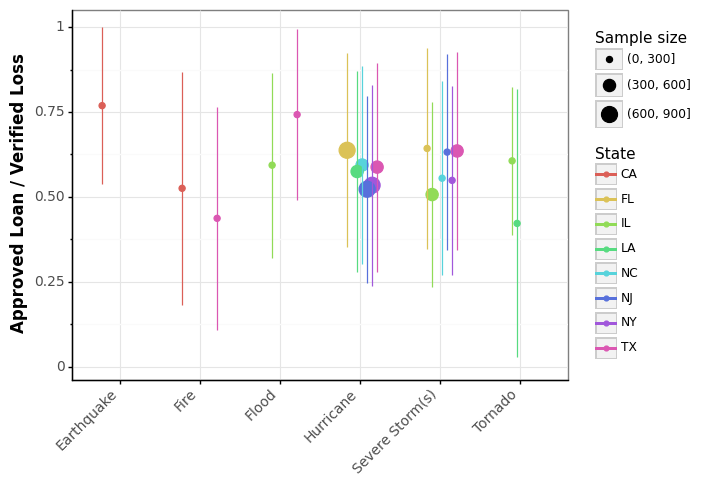

<ggplot: (8744536404661)>

In [ ]:
df_SBA_Individual = df_SBA_All[df_SBA_All['Amount2022Dollars'] < 250000]
df_ApprovalRates = pd.DataFrame()

state = []
hazard = []
ss = []
values = []
values_s = []
df_SBA_All_selected = df_SBA_Individual[df_SBA_Individual['State'].isin(['CA','FL','NY','NJ','NC','TX','LA','IL'])]
for i in df_SBA_All_selected['State'].unique():
  for j in df_SBA_All_selected['Hazard'].unique():
        state.append(i)
        hazard.append(j)
        sample_size,ratio_m,ratio_s = getApprovalAmount(df_SBA_All_selected,i,j)
        ss.append(sample_size + 0.01)
        values.append(ratio_m)
        values_s.append(ratio_s)

df_ApprovalRates['State'] = state
df_ApprovalRates['Hazard'] = hazard
df_ApprovalRates['Size'] = ss
df_ApprovalRates['Size'] = df_ApprovalRates['Size'].apply(lambda x: 900 if x >= 900 else x)
df_ApprovalRates['Sample size'] = pd.cut(df_ApprovalRates['Size'],bins=list(range(0,901,300)))
df_ApprovalRates['Ratio'] = values
df_ApprovalRates['Ratio_ymin'] = df_ApprovalRates['Ratio'] - values_s
df_ApprovalRates['Ratio_ymax'] = df_ApprovalRates['Ratio'] + values_s

# Sort
df_ApprovalRates.sort_values('Sample size')

plot_base = ggplot(df_ApprovalRates,aes(x='Hazard',y='Ratio', color='State',group = 'State'))\
            + geom_point(aes(size='Sample size'),position=position_dodge(0.5))\
            + geom_linerange(aes(ymin='Ratio_ymin', ymax ='Ratio_ymax'),position=position_dodge(0.5))
            #+ geom_linerange(aes(ymin='Ratio_ymin', ymax ='Ratio_ymax',size='Sample size'),alpha=0.75,position=position_dodge(0.95))

plot_clean = plot_base + theme_bw()
plot_clean = plot_clean + theme(
    axis_line=element_line(size=1),
    axis_text=element_text(size=10),
    axis_title=element_text(size=12,face="bold"),
    axis_text_x = element_text(angle = 45, hjust=1)
) +\
scale_x_discrete(name = '') +\
scale_y_continuous(name = 'Approved Loan / Verified Loss', limits=[0.01,1])


ggsave(plot_clean, filename = 'Fig_SBA_ApprovedRatio_byHazard.pdf', path = '/content/drive/MyDrive/SURI/Studies/2022_Wildfires/Figures/')
plot_clean

### Per state

/usr/local/lib/python3.7/dist-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
/usr/local/lib/python3.7/dist-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /content/drive/MyDrive/SURI/Studies/2022_Wildfires/Figures/Fig_SBA_ApprovedRatio_byState.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)
/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 29 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:452: PlotnineWarning: geom_linerange : Removed 29 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
/usr/local/lib/pyt

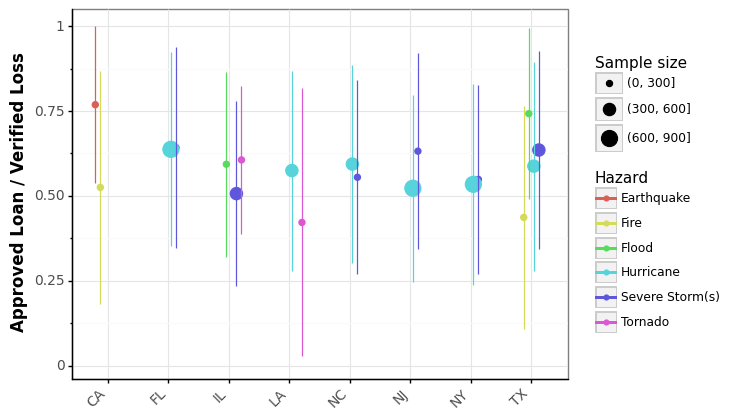

<ggplot: (8744536047965)>

In [ ]:
df_SBA_Individual = df_SBA_All[df_SBA_All['Amount2022Dollars'] < 250000]
df_ApprovalRates = pd.DataFrame()


state = []
hazard = []
ss = []
values = []
values_s = []
df_SBA_All_selected = df_SBA_Individual[df_SBA_Individual['State'].isin(['CA','FL','NY','NJ','NC','TX','LA','IL'])]
for i in df_SBA_All_selected['State'].unique():
  for j in df_SBA_All_selected['Hazard'].unique():
        state.append(i)
        hazard.append(j)
        sample_size,ratio_m,ratio_s = getApprovalAmount(df_SBA_All_selected,i,j)
        ss.append(sample_size + 0.01)
        values.append(ratio_m)
        values_s.append(ratio_s)


df_ApprovalRates['State'] = state
df_ApprovalRates['Hazard'] = hazard
df_ApprovalRates['Size'] = ss
df_ApprovalRates['Size'] = df_ApprovalRates['Size'].apply(lambda x: 900 if x >= 900 else x)
df_ApprovalRates['Sample size'] = pd.cut(df_ApprovalRates['Size'],bins=list(range(0,901,300)))
df_ApprovalRates['Ratio'] = values
df_ApprovalRates['Ratio_ymin'] = df_ApprovalRates['Ratio'] - values_s
df_ApprovalRates['Ratio_ymax'] = df_ApprovalRates['Ratio'] + values_s

# Sort
df_ApprovalRates = df_ApprovalRates.sort_values('Sample size').reset_index(drop=True)

plot_base = ggplot(df_ApprovalRates,aes(x='State',y='Ratio', color='Hazard',group='Hazard'))\
            + geom_point(aes(size='Sample size'),position=position_dodge(0.5))\
            + geom_linerange(aes(ymin='Ratio_ymin', ymax ='Ratio_ymax'),position=position_dodge(0.5))
            #+ geom_linerange(aes(ymin='Ratio_ymin', ymax ='Ratio_ymax',size='Sample size'),alpha=0.75,position=position_dodge(0.95))
            #+ geom_point(aes(size='Sample size'),position=position_dodge(0.5))\

plot_clean = plot_base + theme_bw()
plot_clean = plot_clean + theme(
    axis_line=element_line(size=1),
    axis_text=element_text(size=10),
    axis_title=element_text(size=12,face="bold"),
    axis_text_x = element_text(angle = 45, hjust=1)
) +\
scale_x_discrete(name = '') +\
scale_y_continuous(name = 'Approved Loan / Verified Loss', limits=[0.01,1])


ggsave(plot_clean, filename = 'Fig_SBA_ApprovedRatio_byState.pdf', path = '/content/drive/MyDrive/SURI/Studies/2022_Wildfires/Figures/')
plot_clean

### Split aggregated losses

In [ ]:
def getSplitLosses(theState,theHazard,df_AllLoans,df_FOIAApprovals):

    # Split loans between individual and aggregated
    df_Ind = df_AllLoans[df_AllLoans['Approved Amount Real Estate'] <= 250000].copy()
    df_Agg = df_AllLoans[(df_AllLoans['Approved Amount Real Estate'] > 250000) &\
                         (df_AllLoans['State']==theState) &\
                         (df_AllLoans['Hazard']==theHazard)].copy().reset_index(drop=True)

    # Fit an exponential RV to the approved loans in the FOIA data
    df_ApprovedLoans = df_FOIAApprovals[df_FOIAApprovals['STATE'] == theState].copy()
    X = np.array(df_ApprovedLoans['ORIGINAL_APPROVAL_AMOUNT'], dtype=float)#df_ApprovedLoans['ORIGINAL_APPROVAL_AMOUNT']
    cut,mu = sts.expon.fit(X)

    # Return df
    df_return = pd.DataFrame()
    v_ratio = []
    v_amt = []
    v_loan = []
    v_ddnumber = []
    v_state = []
    v_year = []
    v_hazard = []

    # Loop over each aggregated entry
    for i in range(len(df_Agg.index)):

        # Get the value in this aggregated group
        totalLoan = df_Agg.loc[i,'Approved Amount Real Estate']

        # Get the interest rate for this event
        ir = df_Agg.loc[i,'InflationRate']

        while totalLoan > 0:

            # Estimate approved amount - note, the SBA cap is 200,000
            myApprovedAmount = min(np.random.exponential(mu,1)[0],200000 * ir)

            # Fit a multinomial RV to the Loan-to-Loss ratio for the individual loan data
            theBins = list(range(0,11,1))
            theBins = [x / 10 for x in theBins]

            # Get hold of the approved amount near the randomly assigned to this building
            df_Near = df_Ind[(df_Ind['Approved Amount Real Estate'] > myApprovedAmount - 50000)\
                                                    & (df_Ind['Approved Amount Real Estate'] < myApprovedAmount + 50000)].copy()

            count, division = np.histogram(df_Near[df_Near['Ratio']>0]['Ratio'],bins=theBins)
            p = count/np.sum(count)
            s = list(range(0,10,1))
            s = [x / 10 for x in s]

            # Estimate ratio within the 0.1-brackets
            myRatio = rng.choice(s,p=p,size=1)[0] + rng.random(1)[0]/10
            
            # Main calculations
            v_ratio.append(myRatio)
            v_amt.append(myApprovedAmount)
            v_loan.append(myApprovedAmount/myRatio)

            # Others
            v_ddnumber.append(df_Agg.loc[i,'FEMA Disaster Number'])
            v_state.append(df_Agg.loc[i,'State'])
            v_year.append(df_Agg.loc[i,'Year'])
            v_hazard.append(df_Agg.loc[i,'Hazard'])

            totalLoan -= myApprovedAmount

    df_return['FEMA Disaster Number'] = v_ddnumber
    df_return['State'] = v_state
    df_return['Verified Loss Real Estate'] = v_loan
    df_return['Approved Amount Real Estate'] = v_amt
    df_return['Ratio'] = v_ratio
    df_return['Year'] = v_year
    df_return['Hazard'] = v_hazard

    print('ADDDD THEEE NONO AGGREGATEDDDDD!!!!!!')
    return df_return

### Run example for California

ADDDD THEEE NONO AGGREGATEDDDDD!!!!!!


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8d58388310>]],
      dtype=object)

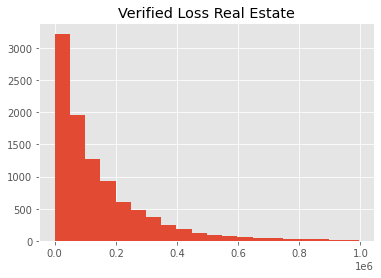

In [ ]:
df_SBA_Extended = getSplitLosses('CA','Fire',df_SBA_All,df_approvals)
df_SBA_Extended[df_SBA_Extended['Verified Loss Real Estate']<1000000].hist('Verified Loss Real Estate',bins=20)

In [ ]:
lossbins = list(range(0,500001,50000))
lossbins.append(1000000)

out = pd.DataFrame()
for i in range(len(lossbins)-1):
    df = df_SBA_Extended.copy()
    df = df[df['Verified Loss Real Estate'].apply(lambda x: True if lossbins[i] <= x < lossbins[i+1] else False)]
    theBins = list(range(0,11,1))
    theBins = [x / 10 for x in theBins]
    count, division = np.histogram(df['Ratio'],bins=theBins)

    out[str(lossbins[i+1])] = count/np.sum(count)
    print(sum(count))

out.to_csv(data_dir+'ApprovalAmountMatrix_CA.txt', index=False)
out

3236
1958
1277
933
601
483
362
240
181
122
408


,50000,100000,150000,200000,250000,300000,350000,400000,450000,500000,1000000
0,0.008653,0.013279,0.014879,0.011790,0.039933,0.062112,0.058011,0.054167,0.088398,0.114754,0.205882
1,0.037392,0.044944,0.064996,0.090032,0.111481,0.124224,0.157459,0.141667,0.193370,0.180328,0.210784
2,0.070148,0.087845,0.107283,0.124330,0.144759,0.153209,0.165746,0.125000,0.132597,0.229508,0.291667
3,0.080346,0.112360,0.118246,0.148982,0.166389,0.182195,0.182320,0.212500,0.171271,0.163934,0.208333
4,0.085290,0.119510,0.136257,0.170418,0.144759,0.196687,0.154696,0.200000,0.220994,0.254098,0.078431
5,0.100124,0.105720,0.129209,0.142551,0.163062,0.120083,0.124309,0.187500,0.176796,0.057377,0.004902
6,0.115884,0.127171,0.120595,0.120043,0.108153,0.074534,0.107735,0.066667,0.016575,0.000000,0.000000
7,0.116811,0.126660,0.126860,0.073955,0.046589,0.047619,0.044199,0.012500,0.000000,0.000000,0.000000
8,0.153894,0.116956,0.098669,0.085745,0.049917,0.037267,0.005525,0.000000,0.000000,0.000000,0.000000
9,0.231459,0.145557,0.083007,0.032154,0.024958,0.002070,0.000000,0.000000,0.000000,0.000000,0.000000


### Only California

/usr/local/lib/python3.7/dist-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(data['x']):


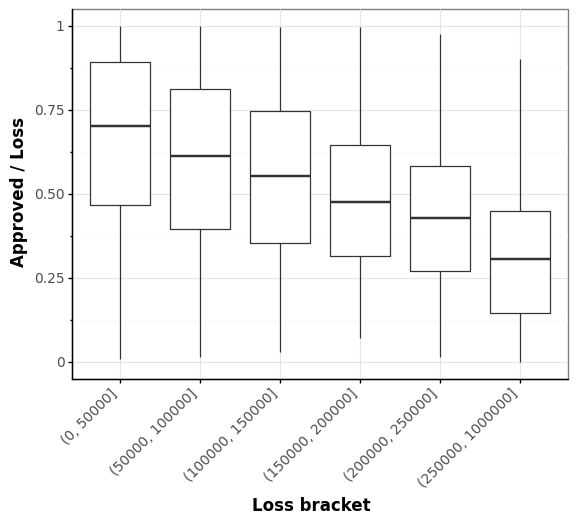

<ggplot: (8765315623397)>

In [ ]:
df_Box = df_SBA_Extended[df_SBA_Extended['State']=='CA'].copy()

lossbins = list(range(0,300000,50000))
lossbins.append(1000000)
df_Box['Verified Loss Real Estate'] = df_Box['Verified Loss Real Estate'].apply(lambda x: x if x < 1000000 else 1000000)
df_Box['Loss Bracket'] = pd.cut(df_Box['Verified Loss Real Estate'],bins=lossbins)

plot_base = ggplot(df_Box) + geom_boxplot(aes(x='Loss Bracket', y='Ratio')) 

plot_clean = plot_base + theme_bw()
plot_clean = plot_clean + theme(
    axis_line=element_line(size=1),
    axis_text=element_text(size=10),
    axis_title=element_text(size=12,face="bold"),
    axis_text_x = element_text(angle = 45, hjust=1)
) +\
scale_x_discrete(name = 'Loss bracket') +\
scale_y_continuous(name = 'Approved / Loss')

#ggsave(plot_clean, filename = 'Fig_SBA_Ratio_vs_Loss_CA.pdf', path = '/content/drive/MyDrive/SURI/Studies/2022_Wildfires/Figures/')

plot_clean



---



---



/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


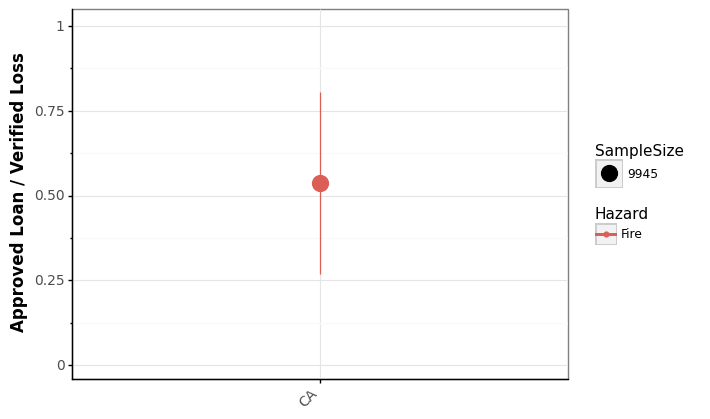

<ggplot: (8765315605345)>

In [ ]:
df_ApprovalRates = pd.DataFrame()

state = []
hazard = []
ss = []
values = []
values_s = []
df_SBA_All_selected = df_SBA_Extended[df_SBA_Extended['State'].isin(['CA','FL','NY','NJ','NC','TX','LA','IL'])]
for i in df_SBA_All_selected['State'].unique():
  for j in df_SBA_All_selected['Hazard'].unique():
        state.append(i)
        hazard.append(j)
        sample_size,ratio_m,ratio_s = getApprovalAmount(df_SBA_All_selected,i,j)
        ss.append(sample_size)
        values.append(ratio_m)
        values_s.append(ratio_s)

df_ApprovalRates['State'] = state
df_ApprovalRates['Hazard'] = hazard
df_ApprovalRates['SampleSize'] = ss
df_ApprovalRates['Ratio'] = values
df_ApprovalRates['Ratio_ymin'] = df_ApprovalRates['Ratio'] - values_s
df_ApprovalRates['Ratio_ymax'] = df_ApprovalRates['Ratio'] + values_s
#df_ApprovalRates.to_csv(data_dir+'df_ApprovalRates.txt')

df_ApprovalRates.sort_values('Ratio')
plot_base = ggplot(df_ApprovalRates,aes(x='State',y='Ratio', color='Hazard'))\
            + geom_point(aes(size='SampleSize'),position=position_dodge(0.5))\
            + geom_linerange(aes(ymin='Ratio_ymin', ymax ='Ratio_ymax'),position=position_dodge(0.5))

plot_clean = plot_base + theme_bw()
plot_clean = plot_clean + theme(
    axis_line=element_line(size=1),
    axis_text=element_text(size=10),
    axis_title=element_text(size=12,face="bold"),
    axis_text_x = element_text(angle = 45, hjust=1)
) +\
scale_x_discrete(name = '') +\
scale_y_continuous(name = 'Approved Loan / Verified Loss', limits=[0.01,1])


#ggsave(plot_clean, filename = 'Fig_SBA_ApprovedRatio_byState.pdf', path = '/content/drive/MyDrive/SURI/Studies/2022_Wildfires/Figures/')
plot_clean

## Get Approved Amount

In [ ]:
df_ApprovalRates = pd.DataFrame()

state = []
hazard = []
values = []
df_SBA_All_selected = df_SBA_Extended[df_SBA_Extended['State'].isin(['CA','FL','NY','TX','LA','MS'])]
for i in df_SBA_All_selected['State'].unique():
  for j in df_SBA_All_selected['Hazard'].unique():
        state.append(i)
        hazard.append(j)
        values.append(getApprovalAmount(df_SBA_All_selected,i,j))

df_ApprovalRates['Approved Amount Real Estate'] = state
df_ApprovalRates['Hazard'] = hazard
df_ApprovalRates['Ratio'] = values
#df_ApprovalRates.to_csv(data_dir+'df_ApprovalRates.txt')

In [ ]:
out = pd.DataFrame()
for i in range(len(lossbins)-1):
    df = df_SBA_All[df_SBA_All['Verified Loss Real Estate'].apply(lambda x: True if lossbins[i] <= x < lossbins[i+1] else False)]
    theBins = list(range(0,11,1))
    theBins = [x / 10 for x in theBins]
    count, division = np.histogram(df['Ratio'],bins=theBins)

    out[str(lossbins[i+1])] = count/np.sum(count)

out.to_csv(data_dir+'ApprovalAmountMatrix.txt', index=False)
out

,50000,100000,150000,200000,250000,1000000
0,0.021941,0.044850,0.050287,0.057546,0.054201,0.035451
1,0.042906,0.088870,0.091236,0.093377,0.077236,0.066765
2,0.060458,0.105482,0.112787,0.111835,0.097561,0.125258
3,0.077279,0.102159,0.132184,0.137894,0.132791,0.170162
4,0.078011,0.108804,0.140086,0.143322,0.191057,0.196160
5,0.087518,0.110465,0.119253,0.135722,0.158537,0.189365
6,0.112384,0.117940,0.116379,0.119435,0.126016,0.124372
7,0.118966,0.110050,0.091236,0.079262,0.073171,0.061448
8,0.162847,0.105066,0.083333,0.076004,0.065041,0.026588
9,0.237689,0.106312,0.063218,0.045603,0.024390,0.004431




---



---



/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:360: PlotnineWarning: stat_boxplot : Removed 4198 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
/usr/local/lib/python3.7/dist-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(data['x']):


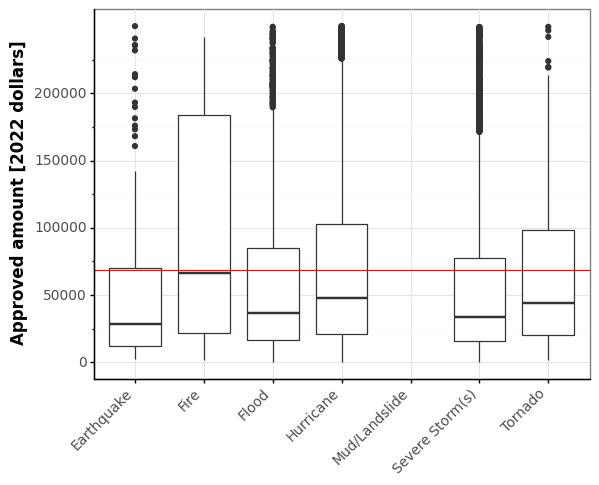

<ggplot: (8765315622977)>

In [ ]:
df_Box = df_SBA_All.copy()
df_Box['Approved Amount Real Estate'] = df_Box['Approved Amount Real Estate'] * df_Box['InflationRate']
df_Box = df_Box[~df_Box['Hazard'].isin(['Volcano','Typhoon','Unknown'])]
plot_base = ggplot(df_Box) + geom_boxplot(aes(x='Hazard', y='Approved Amount Real Estate')) + geom_hline(aes(yintercept=df_Box['Approved Amount Real Estate'].median()),color='red')

plot_clean = plot_base + theme_bw()
plot_clean = plot_clean + theme(
    axis_line=element_line(size=1),
    axis_text=element_text(size=10),
    axis_title=element_text(size=12,face="bold"),
    axis_text_x = element_text(angle = 45, hjust=1)
) +\
scale_x_discrete(name = '') +\
scale_y_continuous(name = 'Approved amount [2022 dollars]',limits=[0,250001],breaks=range(0,250000,50000))

# Save figure
#ggsave(plot_clean, filename = 'Fig_SBA_ApprovalAmount_Hazard.pdf', path = '/content/drive/MyDrive/SURI/Studies/2022_Wildfires/Figures/')

plot_clean

/usr/local/lib/python3.7/dist-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(data['x']):


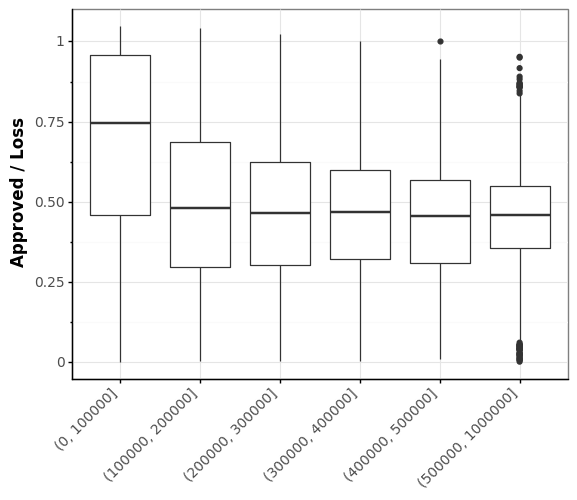

<ggplot: (8765309643989)>

In [ ]:
df_Box = df_SBA_All.copy()

lossbins = list(range(0,600000,100000))
lossbins.append(1000000)
df_Box['Verified Loss Real Estate'] = df_Box['Verified Loss Real Estate'].apply(lambda x: x if x < 1000000 else 1000000)
df_Box['Loss Bracket'] = pd.cut(df_Box['Verified Loss Real Estate'],bins=lossbins)

plot_base = ggplot(df_Box) + geom_boxplot(aes(x='Loss Bracket', y='Ratio')) 

plot_clean = plot_base + theme_bw()
plot_clean = plot_clean + theme(
    axis_line=element_line(size=1),
    axis_text=element_text(size=10),
    axis_title=element_text(size=12,face="bold"),
    axis_text_x = element_text(angle = 45, hjust=1)
) +\
scale_x_discrete(name = '') +\
scale_y_continuous(name = 'Approved / Loss')

#ggsave(plot_clean, filename = 'Fig_SBA_Ratio_vs_Loss_US.pdf', path = '/content/drive/MyDrive/SURI/Studies/2022_Wildfires/Figures/')

plot_clean